<a href="https://colab.research.google.com/github/pmanoonpong/Imageprocessing/blob/main/Copy_of_EX1_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EX1 Classification with Deep CNN
ในตัวอย่างนี้เราจะทำการสร้างโมเดล Deep convolution neural network ด้วย Pytorch เพื่อทำการ Classify Class บน FasionMNIST dataset

**ในตัวอย่างนี้จะแบ่งเป็น 5 Section ดังนี้**

1. เตรียมและทำความเข้าใจ Environment, Dataset 

2. สร้างโมเดล Deep CNN ด้วย Pytorch

3. Training โมเดลด้วยชุดข้อมูล Training set ของ FashionMNIST Dataset

4. Predict ผลลัพธ์ด้วยข้อมูลใน Validation/Test set และ Evaluation ผลลัพธ์ด้วย Accuracy และ Confusion matrix 




#Section ที่ 1: เตรียมและทำความเข้าใจ Environment, Dataset 
**1.1 เริ่มต้นจากการ Import Library และ Package ต่างๆที่จำเป็น**

In [ ]:
# ทำการ Import Library ที่จำเป็นสำหรับการสร้างโมเดล

# Package พื้นฐานสำหรับโครงสร้าง Tensor และกระบวนทางคณิตศาสตร์ต่างๆ
import torch

# Package สำหรับการสร้าง Neural layer ใน Deep learning
import torch.nn as nn
# Package สำหรับ Minimize loss และ Update weight 
import torch.optim as optim 
# Package สำหรับการทำ Convolution operation, Maxpooling และอื่นๆภายใน
import torch.nn.functional as F

# Package สำหรับประมวลผลภาพ โดยจะมีข้อมูล Datasets, โครงสร้างข้อมูล, การ Transform ภาพที่จำเป็นอยู่ภายใน
import torchvision
# Package สำหรับการ Transform ภาพ
import torchvision.transforms as transforms

# ปรับรูปแบบการแสดงผลของ Output
torch.set_printoptions(linewidth=120) 
# ตั้งค่าการติดตาม grad ของ torch.tensor
torch.set_grad_enabled(True)

# สำหรับการแสดงผลรูปภาพ
import matplotlib.pyplot as plt
# สำหรับประมวลผล Array
import numpy as np

# สำหรับการสร้าง Confusion matrix
from sklearn.metrics import confusion_matrix # For confusion matrix visualization
#from resources.plotcm import plot_confusion_matrix

# iteration tools
import itertools


**1.2 ดาวโหลดและตรวจสอบฐานข้อมูลที่จะนำมาใช้**
โดยฐานข้อมูลที่จะนำมาใช้เพื่อ Train network ในตัวอย่างนี้คือ FasionMNIST datasets 

โดยข้อมูลจะต้องผ่านกระบวนการ
1. Extract ข้อมูลจากแหล่งข้อมูล (เช่น website)
2. Transform แปลงข้อมูลให้อยู่ใน Format ที่ต้องการ (ในที่นี้คือ torch.Tensor)
3. Loader โหลดข้อมูลที่แปลงแล้วมาอยู่ในรูปแบบ Structure ที่สามารถส่งเข้าสู่ network ได้

In [ ]:
# ดาวโหลดฐานข้อมูล Fashion MNIST ลงมาบน Directory 

# โครงสร้างข้อมูลนี้เป็น Sub-class ของ torch.utils.data.Dataset
train_set = torchvision.datasets.FashionMNIST(root='./data' ,train=True 
                                              ,download=True       #1. Extract : extract ฐานข้อมูลออกมาจาก url ภายใน
                                              ,transform=transforms.Compose([transforms.ToTensor()])  #2. Transform : ฐานข้อมูลให้อยู่ในรูป Tensor
) 
test_set = torchvision.datasets.FashionMNIST(root='./data' ,train=False 
                                              ,download=True       
                                              ,transform=transforms.Compose([transforms.ToTensor()])  
) 

batch_s = 100 # กำหนดขนาด Batch ในชุดข้อมูล Dataloader = 100 ภาพต่อ batch

validation_ratio = 0.2 # กำหนดอัตราส่วนของ Validation test set
train_ratio = 1-validation_ratio
full_train_size = len(train_set) # 60000
split_point_train = int(full_train_size*train_ratio)



torch.manual_seed(1)
indices = torch.randperm(full_train_size).tolist()

train_set_split      = torch.utils.data.Subset(train_set,indices[:split_point_train])
validation_set_split = torch.utils.data.Subset(train_set,indices[split_point_train:])


train_size = len(train_set_split)
validation_size = len(validation_set_split)
test_size = int(len(test_set))



#3. Loader : โหลดข้อมูลเข้าสู่ torch.utils.data.Dataloader 
train_loader = torch.utils.data.DataLoader(train_set_split, batch_size=batch_s)
validation_loader = torch.utils.data.DataLoader(validation_set_split, batch_size=batch_s)
test_loader = torch.utils.data.DataLoader(test_set ,batch_size=batch_s) 

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


**1.3 ทำความเข้าใจ, ตรวจสอบข้อมูลใน Loader และนำมาแสดงผล (Data visualization)**

ในแต่ละ batch พบว่าเป็น list ซึ่งมี Element สองตัว
- element แรกเป็น Tensor ซึ่งมีรายละเอียดดังนี้
1. มิติ 0 บรรจุภาพไว้ 100 ภาพ
2. มิติ 1 จำนวน Channel ของภาพ (ในที่นี้เป็น 1 เนื่องจากเป็นภาพขาวดำ)
3. มิติ 2 width pixel ของภาพ
4. มิติ 3 height pixel ของภาพ

- element ที่สองเป็น Tensor ซึ่งเก็บ labels 0-9 ซึ่งบ่งบอกชนิดของ class ที่ต้องการทำนาย

In [ ]:
batch = next(iter(train_loader)) # train_loader สามารถวนลูปเพื่อหยิบ batch ย่อยๆออกมาได้ (Iterable object)

print("batch type:",type(batch))
print("batch len :",len(batch))

images, labels = batch
# ตรวจสอบ dimension ของ images, labels
print("\n"+"images size is",images.shape)
print("labels size is",labels.shape )

# ตรวจสอบ element แต่ละตัวภายใน images, labels
#print("images element",images)
print("labels element:",labels)

batch type: <class 'list'>
batch len : 2

images size is torch.Size([100, 1, 28, 28])
labels size is torch.Size([100])
labels element: tensor([2, 7, 6, 1, 6, 0, 3, 8, 8, 8, 6, 7, 1, 3, 9, 4, 1, 6, 9, 2, 9, 6, 3, 2, 2, 2, 6, 5, 0, 1, 4, 6, 6, 0, 9, 8, 6,
        6, 9, 1, 9, 5, 1, 9, 5, 5, 7, 5, 6, 0, 1, 8, 3, 1, 8, 3, 8, 0, 3, 6, 3, 4, 0, 5, 2, 1, 3, 7, 3, 0, 3, 2, 1, 2,
        9, 8, 0, 1, 6, 1, 5, 4, 9, 1, 9, 8, 0, 6, 4, 0, 3, 4, 9, 0, 6, 8, 0, 4, 7, 5])


**1.4 ทดลองแสดงข้อมูลออกมาในรูปแบบภาพ และ Labels class**

Labels of each images: tensor([2, 7, 6, 1, 6, 0, 3, 8, 8, 8])


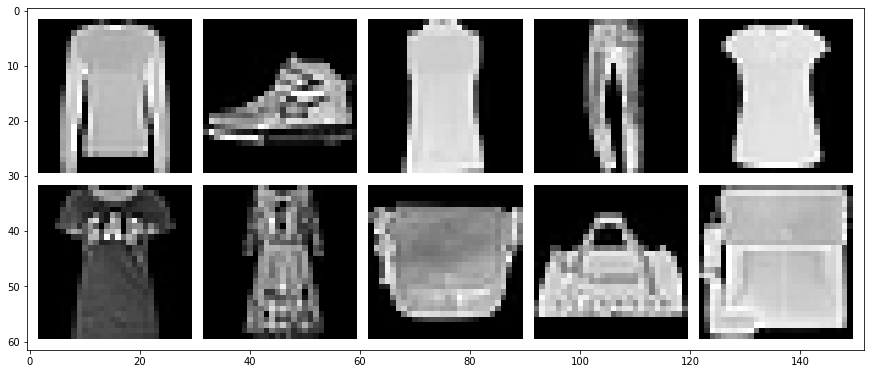

In [ ]:
# แสดงผลภาพ 10 ภาพและ labels 10 ตัวแรกของชุดข้อมูล batch แรก

image_visualize = torchvision.utils.make_grid(images[:10],nrow=5,pad_value = 1)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(image_visualize,(1,2,0)))
print("Labels of each images:",labels[:10])

เมื่อเราเข้าใจโครงสร้างของข้อมูลที่เราจะนำมา feed เข้าโมเดลเราแล้ว ลำดับถัดไปคือการสร้างโมเดลสำหรับ train ข้อมูล

# Section ที่: 2 สร้างโมเดล Deep CNN ด้วย Pytorch

- สำหรับ Pytorch นั้นจะมีการสร้างโมเดลโดยใช้หลักการ Inheritance class 
เพื่อความสะดวกในการกำหนด Hyperparameter และโครงสร้างของ Neural network

- โดย Parent class คือ nn.module 
- และ Child class คือ Net ซึ่งจะมี Hyperparameter และ Structure ต่างๆของ Neural อยู่ภายใน

สิ่งที่เราต้องกำหนดเพิ่มประกอบด้วย Instant variable รวมถึง Method ดังนี้
- ต้องกำหนด dunder init method เพื่อระบุ Layer และ Hyperparameter ต่างๆของ Neural network
- ต้อง define forward method เพื่อทำการ Feedforward Neural network



In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super().__init__()
        # in_channels คือจำนวน channels ของรูปภาพที่ถูก feed เข้ามาใน network (1 = ภาพขาวดำ)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features = 12*4*4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 60)
        self.out = nn.Linear(in_features = 60, out_features = 10)

    def forward(self,input_to_neural):
        #(1) input layer
        f_t = input_to_neural
        
        #(2) hidden conv layer
        f_t = self.conv1(f_t) 
        f_t = F.relu(f_t) 
        f_t = F.max_pool2d(f_t,kernel_size=2, stride = 2)
        
        #(3) hidden conv layer
        f_t = self.conv2(f_t)
        f_t = F.relu(f_t)
        f_t = F.max_pool2d(f_t,kernel_size=2, stride = 2)
        
        #(4) hidden linear layer
        f_t = f_t.reshape(-1,12*4*4) # Flatten input ให้กลายเป็น Tensor มิติเดียว
        f_t = self.fc1(f_t) # กำหนด Fully connect layer
        f_t = F.relu(f_t) # กำหนด Activation function เป็น Rectified linear unit
        
        #(5) hidden linear layer
        f_t = self.fc2(f_t)
        f_t = F.relu(f_t)
        
        #(6) output layer
        f_t = self.out(f_t)

        return f_t

#Section ที่: 3 Training โมเดลด้วยชุดข้อมูล Training set ของ FashionMNIST Dataset
- Feed training set ของเราเข้าไปในโมเดลเพื่อให้โมเดลทำการเรียนรู้ weight ที่เหมาะสมที่สุด ซึ่งสามารถ minimize loss ได้

3.1 Feedforward ค่า Input ผ่านเข้าไปยัง Neural network

3.2 คำนวณหาค่า loss

3.3 Backpropogates ค่า Gradients กลับมายังค่า weight ใน Neural network layer ต่างๆโดยใช้กระบวนการ SGD (หรือ Optimizer ตัวอื่นๆเช่น ADAM)

3.4 นำ Gradient ที่ได้มาปรับค่า Weight

3.5 ทำการวนลูปโดย 2-5 โดยใช้จำนวน Epoch ในการกำหนดครั้งในการวนลูป หรือใช้ Loss เป็นเงื่อนไขในการหยุดวนลูป

In [ ]:
network = Net() # สร้าง Object Deep convolution neural network ตามที่ define ไว้ใน Class Net

# ระบุ Optimizer ที่ต้องการใช้ (ในที่นี้ใช้ SGD)
optimizer = optim.SGD(network.parameters(), lr=0.1) # Learning rate = 0.1

for epoch in range(10):
    
    total_loss = 0
    total_correct = 0

    for batch in train_loader:

        images, labels = batch

        # ( ขั้นตอนที่ 3.1 ) Feedforward ค่า Input ผ่านเข้าไปยัง Neural network
        preds = network(images) 
        # ____________________________________________________________

        # ( ขั้นตอนที่ 3.2 ) คำนวนหาค่า Loss
        loss = F.cross_entropy(preds, labels) 
        #_____________________________________________________________

        optimizer.zero_grad() #reset ค่าใน grad ให้เป็น 0 ก่อนคำนวนค่าใหม่ (default ของ grad จะทำการ accumulate ค่าไปเรื่อยๆ)

        # ( ขั้นตอนที่ 3.3 ) Backpropogates ค่า Gradients ของ weight แต่ละตัวใน Neural network layer ต่างๆโดยใช้กระบวนการ SGD (หรือ Optimizer ตัวอื่นๆเช่น ADAM)
        loss.backward() 
        #_____________________________________________________________

        # ( ขั้นตอนที่ 3.4 ) Updates ค่า weights ของ Network จาก Gradients ที่ได้
        optimizer.step() 
        #_____________________________________________________________


        total_loss += loss.item() #รับข้อมูลจากค่าที่อยู่ใน tensor 0 มิติและบวกเข้าไปใน loss ทั้งหมด

        # ( ขั้นตอนที่ 3.5 ) วนลูปตามจำนวน Epochs ที่ได้ตั้งไว้
        
    print("epoch:", epoch+1,"total_loss_in_batch:", total_loss )

epoch: 1 total_loss_in_batch: 623.5471002161503
epoch: 2 total_loss_in_batch: 275.51110062003136
epoch: 3 total_loss_in_batch: 230.77275803685188
epoch: 4 total_loss_in_batch: 205.59873369336128
epoch: 5 total_loss_in_batch: 187.48274920880795
epoch: 6 total_loss_in_batch: 174.73120641708374
epoch: 7 total_loss_in_batch: 165.15017607808113
epoch: 8 total_loss_in_batch: 157.51086547970772
epoch: 9 total_loss_in_batch: 151.09381365776062
epoch: 10 total_loss_in_batch: 145.61040657758713


จากขั้นตอนดังกล่าว โมเดลเราจะได้ค่า weight มาเป็นที่เรียบร้อย ขั้นตอนถัดไปจะทดสอบความแม่นยำของ model ที่ได้สร้างขึ้นมา

#Section ที่: 4 Predict ผลลัพธ์ด้วยข้อมูลใน Validation/Test set และ Evaluation ผลลัพธ์ด้วย Accuracy และ Confusion matrix 

- ผลลัพธ์ที่ได้ออกมาจากการทำนาย จะมีลักษณะเป็น Tensor ขนาด nxm 
โดยที่ n คือจำนวน Data และ m คือจำนวน Class ซึ่งทำนายออกมาในลักษณะของความน่าจะเป็น

**4.1 Predict ผลลัพธ์ด้วยข้อมูลใน Test Loader**


In [ ]:
predict = network(images) # รูปแบบการ Predict จะกระทำในลักษณะของ Feedforward
print(predict.shape)

torch.Size([100, 10])


จะได้ tensor สองมิติโดย
- มิติแรกมีขนาด 100 (ขนาด batch) 
- มิติที่สองมีขนาด 10 (ความน่าจะเป็นในการ predict แต่ละ class)

In [ ]:
# เขียน Function สำหรับ Predict ผลลัพธ์ที่ได้ออกมาจากโมเดล โดยจะเลือก index ที่มีความน่าจะเป็นมากที่สุด
# จากนั้นนำค่าที่ predict และ labels ทั้งหมดมาต่อเป็น Tensor ผลลัพธ์ที่รวมการ predict ทุก batch ไว้ด้วยกัน
 
@torch.no_grad() # ไม่ใช้ความสามารถของ autograd ในขั้นตอนนี้
def get_preds_labels(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        preds_label = preds.argmax(dim=1).float()

        all_preds = torch.cat((all_preds, preds_label))
        all_labels = torch.cat((all_labels, labels.float()))


    return all_preds,all_labels

In [ ]:
all_preds, all_labels = get_preds_labels(network,test_loader)

**4.2 Evaluation ผลลัพธ์ด้วย Accuracy**

In [ ]:
total_correct_predict = sum(all_preds == all_labels).item() 
accuracy = total_correct_predict/ validation_size
print("Model มีความ Accuracy เท่ากับ",100*accuracy,"%")

Model มีความ Accuracy เท่ากับ 72.93333333333332 %


**4.3 Evaluation ผลลัพธ์ด้วย Confusion matrix**

In [ ]:
stacked = torch.stack((all_labels,all_preds),dim=1) # นำ Tensor prediction และ labels มา stack กันเพื่อเตรียมใช้เป็นข้อมูลสำหรับสร้าง Confusion matrix

In [ ]:
con_matrix = torch.zeros(10,10,dtype=torch.int64)

In [ ]:
# สร้าง Confusion matrix ในรูปแบบ Row/Column
for e in stacked:
  label,predict = [int(el) for el in (e.tolist())]
  con_matrix[label,predict] = con_matrix[label,predict]+1

In [ ]:
con_matrix

tensor([[748,   3,  14,  73,   4,   1, 145,   0,  10,   2],
        [  0, 972,   0,  22,   2,   0,   3,   0,   1,   0],
        [ 13,   4, 745,  14, 138,   0,  83,   0,   3,   0],
        [  8,   5,   9, 916,  32,   0,  27,   0,   3,   0],
        [  0,   1,  46,  22, 856,   1,  69,   0,   5,   0],
        [  0,   0,   0,   2,   0, 950,   0,  34,   0,  14],
        [ 96,   0,  64,  40,  86,   0, 692,   0,  22,   0],
        [  0,   0,   0,   0,   0,  14,   0, 942,   0,  44],
        [  0,   1,   9,   5,   4,   2,   4,   5, 970,   0],
        [  0,   0,   0,   0,   0,   7,   0,  31,   1, 961]])

In [ ]:
classes = test_set.classes # สร้าง list ของ class สำหรับส่งเข้าไปในฟังก์ชันช่วย plot confusion matrix

In [ ]:
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
# Function ช่วยในการ Plot Confusion matrix โดยใช้ข้อมูลจาก con_matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[748,   3,  14,  73,   4,   1, 145,   0,  10,   2],
        [  0, 972,   0,  22,   2,   0,   3,   0,   1,   0],
        [ 13,   4, 745,  14, 138,   0,  83,   0,   3,   0],
        [  8,   5,   9, 916,  32,   0,  27,   0,   3,   0],
        [  0,   1,  46,  22, 856,   1,  69,   0,   5,   0],
        [  0,   0,   0,   2,   0, 950,   0,  34,   0,  14],
        [ 96,   0,  64,  40,  86,   0, 692,   0,  22,   0],
        [  0,   0,   0,   0,   0,  14,   0, 942,   0,  44],
        [  0,   1,   9,   5,   4,   2,   4,   5, 970,   0],
        [  0,   0,   0,   0,   0,   7,   0,  31,   1, 961]])


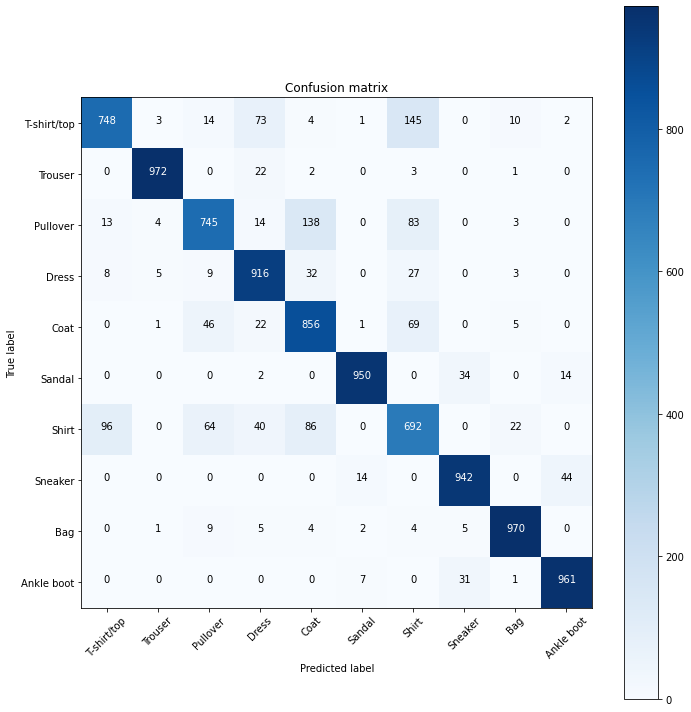

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(con_matrix, classes)

# สรุปผล
- รูปแบบการประมวลผลดังกล่าวสามารถประยุกต์ใช้กับงาน Classification เพื่อตรวจสอบความสามารถในการ Predict Class รวมทั้งตรวจสอบจุดอ่อนในโมเดลได้โดยสะดวกมากยิ่งขึ้น
- จาก Confusion matrix จะพบว่า Shirt และ T-Shirt มีค่า Precition และ Recall ที่ค่อนข้างต่ำกว่า Classes อื่น ซึ่งเราสามารถนำข้อมูล ณ จุดนี้มาพัฒนาโมเดลของเราต่อไปได้



# - - - - - - - - - - - - - - - - - - - - - - - - QUIZ - - - - - - - - - - - -- - - - - - - - - - - -

1. จงทดลองสร้างโมเดล Deep neural network เพื่อทำการเทรนโมเดลสำหรับ Classification บน FashionMNIST Dataset

โดยโมเดล มี Requirement ดังนี้
- Input layer เป็น Tensor ขนาด (N,num_in) โดย N แทนจำนวนภาพทั้งหมดใน 1 batch และ num_in เป็น Tensor ภาพที่ถูก Flatten ให้เหลือเพียง 1 มิติ
- มีจำนวน Hidden layer จำนวน 2 Layer
- Hidden Layer ที่หนึ่งมีขนาด Neural จำนวน 200 Neural มี Activation Function เป็น Sigmoid Function
- Hidden Layer ที่สองมีขนาด Neural จำนวน 60 Neural มี Activation Function เป็น Sigmoid Function
- Output Layer เป็นความน่าจะเป็นที่จะ Predict Class แต่ละ Class ออกมาในรูปแบบเลข 0-1


จากนั้นจงทำการ Train model โดยใช้ Optimizer ที่ชื่อว่า SGD ด้วย learning rate 0.1 และจำนวน Epoch ทั้งหมด 10 Epoch

และทำการ Predict ตรวจสอบ Accuracy ของโมเดลที่ได้

- ข้อแนะนำ: ให้ทำการเปิด document API ของ PyTorch ควบคู่กันไปขณะทำ Exercise นี้

In [ ]:
class my_network(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features = ???????? , out_features = ????????)
        self.fc2 = nn.Linear(in_features = ???????? , out_features = ????????)
        self.out = nn.Linear(in_features = ???????? , out_features = ????????)

    def forward(self,input_to_neural):
        f_t = input_to_neural
        f_t = ?????????????  # flatten หรือ reshape input ให้มีขนาดตาม Requirment ของ nn.Linear
        
        # hidden layer ที่ 1
        f_t = self.fc1(f_t)
        f_t = ???????????? # กำหนด Activation function sigmoid
        
        # hidden layer ที่ 2
        f_t = self.fc2(f_t)
        f_t = ???????????
        
        # output layer
        f_t = self.out(f_t)

        return f_t

In [ ]:
My_Network = my_network() 

optimizer = ?????????? # กำหนด Optimizer SGD ให้ My_Network ด้วย Learning rate ที่โจทย์กำหนด

for epoch in range( ????? ): # กำหนด Epoch 
    
    total_loss = 0
    total_correct = 0

    for batch in train_loader:

        images, labels = batch
        preds = My_Network(images) 
        loss = F.cross_entropy(preds, labels) 
        optimizer.zero_grad() #reset ค่าใน grad ให้เป็น 0 ก่อนคำนวนค่าใหม่ (default ของ grad จะทำการ accumulate ค่าไปเรื่อยๆ)
        loss.backward() 
        optimizer.step() 
        total_loss += loss.item() 

        # วนลูปตามจำนวน Epochs ที่ได้ตั้งไว้
        
    print("epoch:", epoch+1,"total_loss_in_batch:", total_loss )

In [ ]:
predict = My_Network(images) 
all_preds, all_labels = get_preds_labels(My_Network,test_loader)
total_correct_predict = sum(all_preds == all_labels).item() 
accuracy = total_correct_predict/ validation_size
print("Model มีความ Accuracy เท่ากับ",100*accuracy,"%")

# - - - - - - - - - - - - - - - - - - - - - - - - เฉลย - - - - - - - - - - - -- - - - - - - - - - - -

In [ ]:
class my_network(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features = 784, out_features = 200)
        self.fc2 = nn.Linear(in_features = 200, out_features = 60)
        self.out = nn.Linear(in_features = 60, out_features = 10)

    def forward(self,input_to_neural):
        f_t = input_to_neural
        f_t = torch.flatten(f_t,start_dim=1) # Flatten input ให้กลายเป็น Tensor มิติเดียว
        
        f_t = self.fc1(f_t) # กำหนด Fully connect layer
        f_t = torch.sigmoid(f_t) # กำหนด Activation function เป็น Sigmoid
        #(5) hidden linear layer
        f_t = self.fc2(f_t)
        f_t = torch.sigmoid(f_t)
        
        #(6) output layer
        f_t = self.out(f_t)

        return f_t

In [ ]:
My_Network = my_network() 

optimizer = optim.SGD(My_Network.parameters(), lr=0.1) 

for epoch in range(10):
    
    total_loss = 0
    total_correct = 0

    for batch in train_loader:

        images, labels = batch

        preds = My_Network(images) 

        loss = F.cross_entropy(preds, labels) 

        optimizer.zero_grad() #reset ค่าใน grad ให้เป็น 0 ก่อนคำนวนค่าใหม่ (default ของ grad จะทำการ accumulate ค่าไปเรื่อยๆ)

        loss.backward() 
        optimizer.step() 
        total_loss += loss.item() #รับข้อมูลจากค่าที่อยู่ใน tensor 0 มิติและบวกเข้าไปใน loss ทั้งหมด

        # วนลูปตามจำนวน Epochs ที่ได้ตั้งไว้
        
    print("epoch:", epoch+1,"total_loss_in_batch:", total_loss )

epoch: 1 total_loss_in_batch: 1009.4917145967484
epoch: 2 total_loss_in_batch: 584.8127088546753
epoch: 3 total_loss_in_batch: 446.6893775463104
epoch: 4 total_loss_in_batch: 368.1405837535858
epoch: 5 total_loss_in_batch: 320.77993083000183
epoch: 6 total_loss_in_batch: 294.6831544339657
epoch: 7 total_loss_in_batch: 276.4106014370918
epoch: 8 total_loss_in_batch: 262.3352288007736
epoch: 9 total_loss_in_batch: 251.14074218273163
epoch: 10 total_loss_in_batch: 241.9728957414627


In [ ]:
predict = My_Network(images) 
all_preds, all_labels = get_preds_labels(My_Network,test_loader)
total_correct_predict = sum(all_preds == all_labels).item() 
accuracy = total_correct_predict/ validation_size
print("Model มีความ Accuracy เท่ากับ",100*accuracy,"%")

Model มีความ Accuracy เท่ากับ 67.43333333333334 %


In [ ]:
stacked = torch.stack((all_labels,all_preds),dim=1) # นำ Tensor prediction และ labels มา stack กันเพื่อเตรียมใช้เป็นข้อมูลสำหรับสร้าง Confusion matrix
con_matrix = torch.zeros(10,10,dtype=torch.int64)
# สร้าง Confusion matrix ในรูปแบบ Row/Column
for e in stacked:
  label,predict = [int(el) for el in (e.tolist())]
  con_matrix[label,predict] = con_matrix[label,predict]+1

Confusion matrix, without normalization
tensor([[751,   3,   6,  93,   4,   2, 127,   0,  14,   0],
        [  0, 929,  13,  47,   5,   0,   4,   0,   2,   0],
        [ 14,   1, 631,  10, 215,   0, 119,   0,  10,   0],
        [ 30,   9,   8, 839,  44,   0,  65,   0,   5,   0],
        [  0,   0,  66,  29, 825,   0,  74,   0,   6,   0],
        [  0,   0,   0,   1,   0, 869,   0,  68,  12,  50],
        [138,   2, 110,  55, 188,   1, 473,   0,  33,   0],
        [  0,   0,   0,   0,   0,  31,   0, 895,   0,  74],
        [  0,   1,   4,   7,   3,   6,  38,   4, 935,   2],
        [  0,   0,   0,   0,   0,  16,   0,  37,   2, 945]])


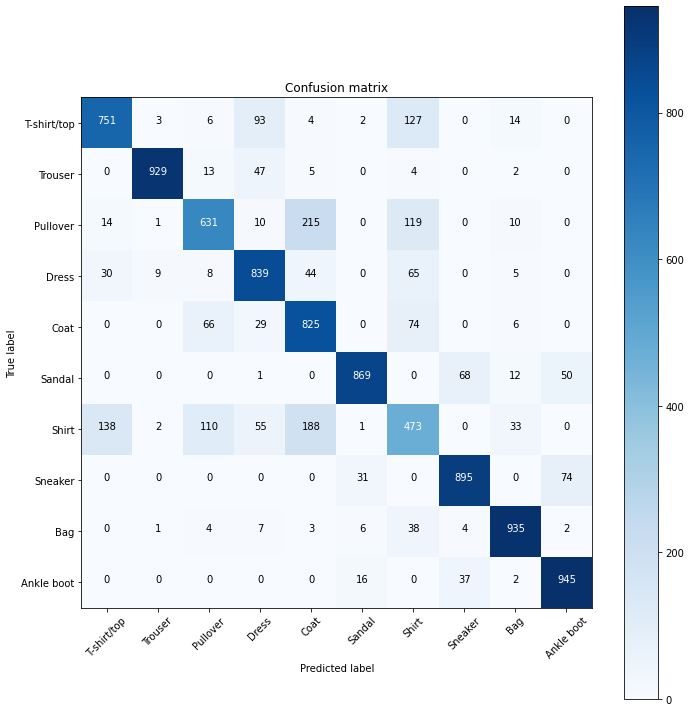

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(con_matrix, classes)